In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, cross_val_score, validation_curve

### California Hoising Dataset - Overfitting and underfitting

In [2]:
#Reading data
housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
#Target changed to $Thoushands
target = target * 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

In [4]:
#Using DecisionTreeRegressor for the model
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)
pred = regressor.predict(data)

#Testing on same training data - Errpr should be Zero
score = mean_absolute_error(target, pred)
print(f'Regressor average error: {score:.3f}')

Regressor average error: 0.000


In [5]:
#Spliting data
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=0)
regressor.fit(X_train, y_train)

# Zero error on training set - Should be Zero
pred = regressor.predict(X_train)
score = mean_absolute_error(y_train, pred)
print(f'Regressor average error on training set: {score:.3f}')

# Error on test set
pred = regressor.predict(X_test)
score = mean_absolute_error(y_test, pred)
print(f'Regressor average error on test set: ${score:.2f}K')

Regressor average error on training set: 0.000
Regressor average error on test set: $47.28K


### Crossvalidation

In [6]:
#Cross-Validation
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_res = cross_validate(regressor, data, target, cv=cv, scoring='neg_mean_absolute_error')
cv_res = pd.DataFrame(cv_res)
cv_res['test_error'] = -1 * cv_res.test_score
cv_res.head(10)

,fit_time,score_time,test_score,test_error
0,0.100497,0.000000,-46.909797,46.909797
1,0.113936,0.000000,-46.421170,46.421170
2,0.110135,0.003001,-47.411089,47.411089
3,0.099395,0.000000,-44.319824,44.319824
4,0.105230,0.004569,-47.607875,47.607875
5,0.093188,0.010128,-45.901300,45.901300
6,0.100881,0.000000,-46.572767,46.572767
7,0.101216,0.007832,-46.194585,46.194585
8,0.099962,0.002048,-45.590236,45.590236
9,0.099045,0.012083,-45.727998,45.727998


Mean cross-validation error is: $46.36K ± $1.17K


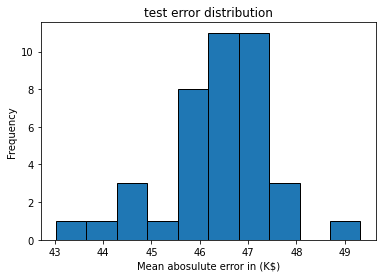

In [7]:
#plot test error distribution
sym = '\u00B1'
cv_res.test_error.plot.hist(bins=10, edgecolor='black')
plt.xlabel('Mean abosulute error in (K$)')
_ = plt.title('test error distribution')
error = cv_res.test_error
print(f'Mean cross-validation error is: ${error.mean():.2f}K {sym} ${error.std():.2f}K')

Standard deviation of Target distribution: $115.40K


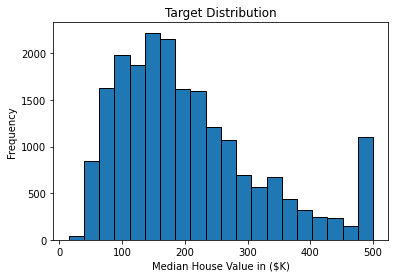

In [8]:
#Plot target distribution
target.plot.hist(bins=20, edgecolor='black')
plt.xlabel('Median House Value in ($K)')
_ = plt.title('Target Distribution')
print(f'Standard deviation of Target distribution: ${target.std():.2f}K')

In [9]:
#More regarding Cross-Validation - Check estimators
cv = cross_validate(regressor, data, target, return_estimator=True)
print(cv)
cv['estimator']

{'fit_time': array([0.14177823, 0.11794233, 0.10562134, 0.11653352, 0.10631657]), 'score_time': array([0.00301409, 0.        , 0.        , 0.00201631, 0.        ]), 'estimator': [DecisionTreeRegressor(random_state=0), DecisionTreeRegressor(random_state=0), DecisionTreeRegressor(random_state=0), DecisionTreeRegressor(random_state=0), DecisionTreeRegressor(random_state=0)], 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}


[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

In [10]:
#Get scores
scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

### Overfit-Generalization-Underfit

In [35]:
# Crossvalidation and scores
cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target, cv=cv, scoring='neg_mean_absolute_error',
                           return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
scores = pd.DataFrame()
scores[['train_error', 'test_error']] = -cv_results[['train_score', 'test_score']]

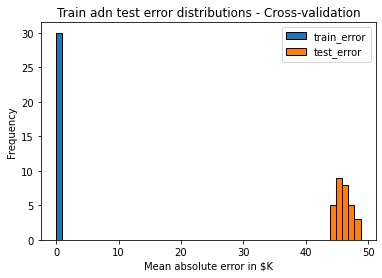

In [36]:
# Plotting error distributions
scores.plot.hist(bins=50, edgecolor='black')
plt.xlabel('Mean absolute error in $K')
_ = plt.title('Train adn test error distributions - Cross-validation')

### Validation Curve

In [32]:
#Getting val and test errors for different tree depths
max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(regressor, data, target, param_name='max_depth', param_range=max_depth,
                                            cv=cv, scoring='neg_mean_absolute_error', n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

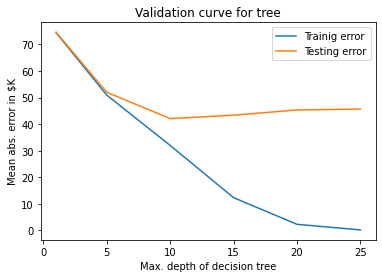

In [33]:
#Plotting train and test error curves
plt.plot(max_depth, train_errors.mean(axis=1), label='Trainig error')
plt.plot(max_depth, test_errors.mean(axis=1), label='Testing error')
plt.legend()

plt.xlabel('Max. depth of decision tree')
plt.ylabel('Mean abs. error in $K')
_ = plt.title('Validation curve for tree')

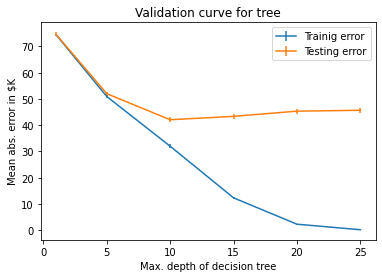

In [34]:
#Plotting train and test error curves and std
plt.errorbar(max_depth, train_errors.mean(axis=1), yerr=train_erros.std(axis=1), label='Trainig error')
plt.errorbar(max_depth, test_errors.mean(axis=1), yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel('Max. depth of decision tree')
plt.ylabel('Mean abs. error in $K')
_ = plt.title('Validation curve for tree')